In [1]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, roc_curve
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

# Ensure inline visualizations for plots
%matplotlib inline

# GPU setup: Checking for 2xT4 GPUs
if torch.cuda.is_available():
    print(f"CUDA is available. Device name: {torch.cuda.get_device_name(0)}")
    print(f"Total GPUs available: {torch.cuda.device_count()}")
    if torch.cuda.device_count() >= 2:
        print("2xT4 GPUs are available. Notebook is ready for GPU acceleration.")
    else:
        print("Fewer than 2 GPUs available. This may impact performance.")
else:
    print("CUDA is not available. Falling back to CPU.")

# Optional: Set the accelerator preference for custom usage
accelerator = "GPU" if torch.cuda.is_available() else "CPU"
print(f"Using {accelerator} for computations.")


CUDA is not available. Falling back to CPU.
Using CPU for computations.


# Project Overview

The goal of this notebook is to analyze and predict **online shoppers' purchasing intentions** using machine learning models. This dataset consists of various features such as the number of pages visited, time spent on different types of pages, and demographic data of online shoppers, with the aim to determine whether a shopper is likely to make a purchase.

## Key Objectives:
This project approaches the problem as a **binary classification task**, where the target variable (`Revenue`) indicates whether a purchase was made (`1`) or not (`0`). 

### Steps in the Project:
1. **Exploratory Data Analysis (EDA):**
   - Understand data distribution.
   - Visualize correlations and relationships between features and the target variable.
   
2. **Data Preprocessing:**
   - Handle missing values, if any.
   - Standardize and scale numerical features.
   - Encode categorical variables.

3. **Model Development:**
   - Train multiple models (e.g., Logistic Regression, Random Forest, SVM, etc.).
   - Evaluate performance using metrics like accuracy, ROC-AUC, precision, recall, and F1-score.
   - Visualize key results, including ROC curves, feature importances, and confusion matrices.

4. **Optimization:**
   - Tune hyperparameters for the best-performing models.
   - Compare results and identify the most optimal model for deployment.

5. **Insights:**
   - Derive actionable insights from feature importances and patterns in the data.

---

**Next Step:** Load the data and explore its structure to get a better understanding.


#### **Description**
In this step, we load the dataset and begin exploring it to understand its structure, key statistics, and any preprocessing needs. This involves:
- Checking the dataset's structure.
- Viewing key descriptive statistics.
- Understanding column data types and identifying any potential issues.

Loading the dataset and performing an initial review is crucial for understanding the data we are working with.


In [2]:
# Load the dataset
data_path = '/kaggle/input/online-shoppers-purchase-intention/online_shoppers_intention.csv'

# Reading the dataset into a DataFrame
df = pd.read_csv(data_path)

# Display the first few rows of the dataset
print("Dataset loaded successfully. Here are the first few rows:") 
display(df.head())

# Display basic information about the dataset
print("\nDataset Info:")
df.info()

# Summary statistics for numerical columns
print("\nSummary Statistics:")
display(df.describe())


Dataset loaded successfully. Here are the first few rows:


,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False



Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  Traffic

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType
count,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000
mean,2.315166,80.818611,0.503569,34.472398,31.731468,1194.746220,0.022191,0.043073,5.889258,0.061427,2.124006,2.357097,3.147364,4.069586
std,3.321784,176.779107,1.270156,140.749294,44.475503,1913.669288,0.048488,0.048597,18.568437,0.198917,0.911325,1.717277,2.401591,4.025169
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,7.000000,184.137500,0.000000,0.014286,0.000000,0.000000,2.000000,2.000000,1.000000,2.000000
50%,1.000000,7.500000,0.000000,0.000000,18.000000,598.936905,0.003112,0.025156,0.000000,0.000000,2.000000,2.000000,3.000000,2.000000
75%,4.000000,93.256250,0.000000,0.000000,38.000000,1464.157214,0.016813,0.050000,0.000000,0.000000,3.000000,2.000000,4.000000,4.000000
max,27.000000,3398.750000,24.000000,2549.375000,705.000000,63973.522230,0.200000,0.200000,361.763742,1.000000,8.000000,13.000000,9.000000,20.000000


In [3]:
# description of dataset
df.describe()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType
count,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000
mean,2.315166,80.818611,0.503569,34.472398,31.731468,1194.746220,0.022191,0.043073,5.889258,0.061427,2.124006,2.357097,3.147364,4.069586
std,3.321784,176.779107,1.270156,140.749294,44.475503,1913.669288,0.048488,0.048597,18.568437,0.198917,0.911325,1.717277,2.401591,4.025169
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,7.000000,184.137500,0.000000,0.014286,0.000000,0.000000,2.000000,2.000000,1.000000,2.000000
50%,1.000000,7.500000,0.000000,0.000000,18.000000,598.936905,0.003112,0.025156,0.000000,0.000000,2.000000,2.000000,3.000000,2.000000
75%,4.000000,93.256250,0.000000,0.000000,38.000000,1464.157214,0.016813,0.050000,0.000000,0.000000,3.000000,2.000000,4.000000,4.000000
max,27.000000,3398.750000,24.000000,2549.375000,705.000000,63973.522230,0.200000,0.200000,361.763742,1.000000,8.000000,13.000000,9.000000,20.000000


#### **Description**
Checking for missing values ensures the dataset is clean and ready for analysis. Missing data can impact the performance of our models. Here’s what we’ll do:
- Identify any columns with missing values.
- Review the total count of missing values for each column.
- Decide on an appropriate handling strategy (if required).


In [4]:
# Check for missing values
print("Checking for missing values:")
missing_values = df.isnull().sum()
display(missing_values[missing_values > 0])

if missing_values.sum() == 0:
    print("No missing values found.")
else:
    print("Missing values detected. Preprocessing required.")


Checking for missing values:


Series([], dtype: int64)

No missing values found.



The target variable `Revenue` represents whether a purchase was made (1) or not (0). Understanding its distribution is crucial for:
- Identifying class imbalances.
- Deciding on appropriate metrics for model evaluation.
- Adjusting our modeling approach if needed.

We’ll visualize the distribution of `Revenue` to gain further insights.


Analyzing the target variable ('Revenue'):
Revenue
False    10422
True      1908
Name: count, dtype: int64


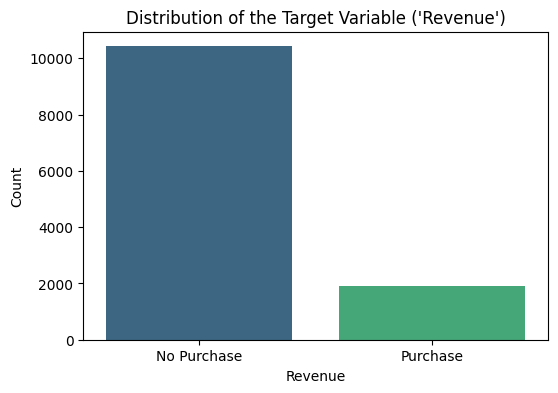

In [5]:
# Analyze the target variable
print("Analyzing the target variable ('Revenue'):")
target_counts = df['Revenue'].value_counts()
print(target_counts)

# Visualizing the distribution of the target variable
plt.figure(figsize=(6, 4))
sns.barplot(x=target_counts.index, y=target_counts.values, palette="viridis")
plt.title("Distribution of the Target Variable ('Revenue')")
plt.xlabel("Revenue")
plt.ylabel("Count")
plt.xticks([0, 1], labels=["No Purchase", "Purchase"])
plt.show()



Understanding the relationships between features and the target variable is essential for feature selection and engineering. Here's what we will do:
1. Calculate the correlation matrix for numerical features.
2. Visualize the correlation matrix using a heatmap.
3. Plot the distribution of key features, focusing on how they relate to the target variable (`Revenue`).



The correlation matrix computation is limited to numerical columns. To fix the error:
1. Filter out non-numerical columns from the dataset.
2. Proceed with computing correlations for the remaining numerical features.
This step avoids issues caused by categorical data in the correlation analysis.


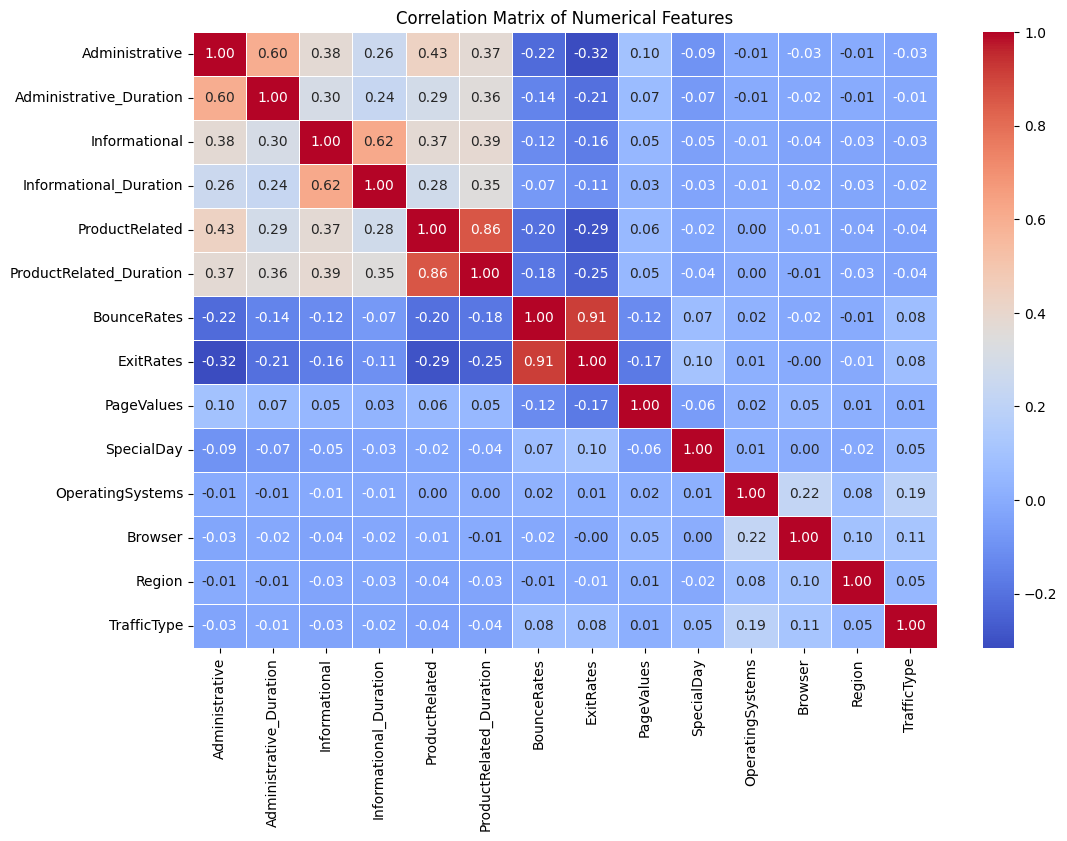

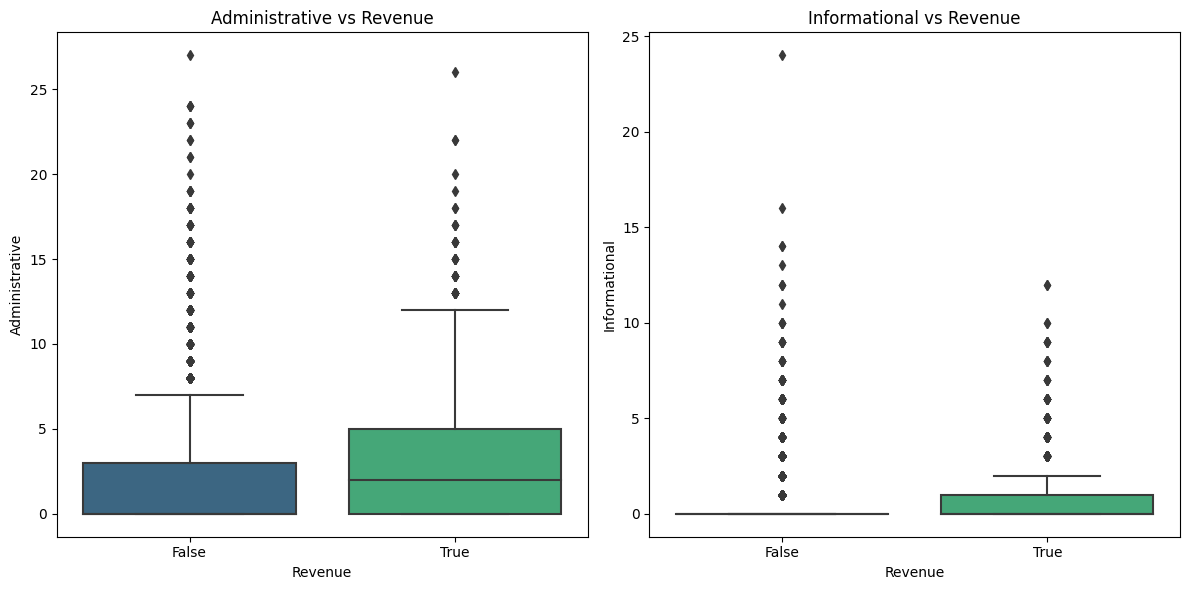

In [6]:
# Select only numerical columns for correlation analysis
numerical_df = df.select_dtypes(include=[np.number])

# Calculate the correlation matrix
correlation_matrix = numerical_df.corr()

# Plotting the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix of Numerical Features")
plt.show()

# Example of plotting feature distributions against the target
plt.figure(figsize=(12, 6))

# Example 1: Administrative feature with Revenue
plt.subplot(1, 2, 1)
sns.boxplot(x='Revenue', y='Administrative', data=df, palette="viridis")
plt.title("Administrative vs Revenue")
plt.xlabel("Revenue")
plt.ylabel("Administrative")

# Example 2: Informational feature with Revenue
plt.subplot(1, 2, 2)
sns.boxplot(x='Revenue', y='Informational', data=df, palette="viridis")
plt.title("Informational vs Revenue")
plt.xlabel("Revenue")
plt.ylabel("Informational")

plt.tight_layout()
plt.show()


array([[<Axes: title={'center': 'Administrative'}>,
        <Axes: title={'center': 'Administrative_Duration'}>,
        <Axes: title={'center': 'Informational'}>,
        <Axes: title={'center': 'Informational_Duration'}>],
       [<Axes: title={'center': 'ProductRelated'}>,
        <Axes: title={'center': 'ProductRelated_Duration'}>,
        <Axes: title={'center': 'BounceRates'}>,
        <Axes: title={'center': 'ExitRates'}>],
       [<Axes: title={'center': 'PageValues'}>,
        <Axes: title={'center': 'SpecialDay'}>,
        <Axes: title={'center': 'OperatingSystems'}>,
        <Axes: title={'center': 'Browser'}>],
       [<Axes: title={'center': 'Region'}>,
        <Axes: title={'center': 'TrafficType'}>, <Axes: >, <Axes: >]],
      dtype=object)

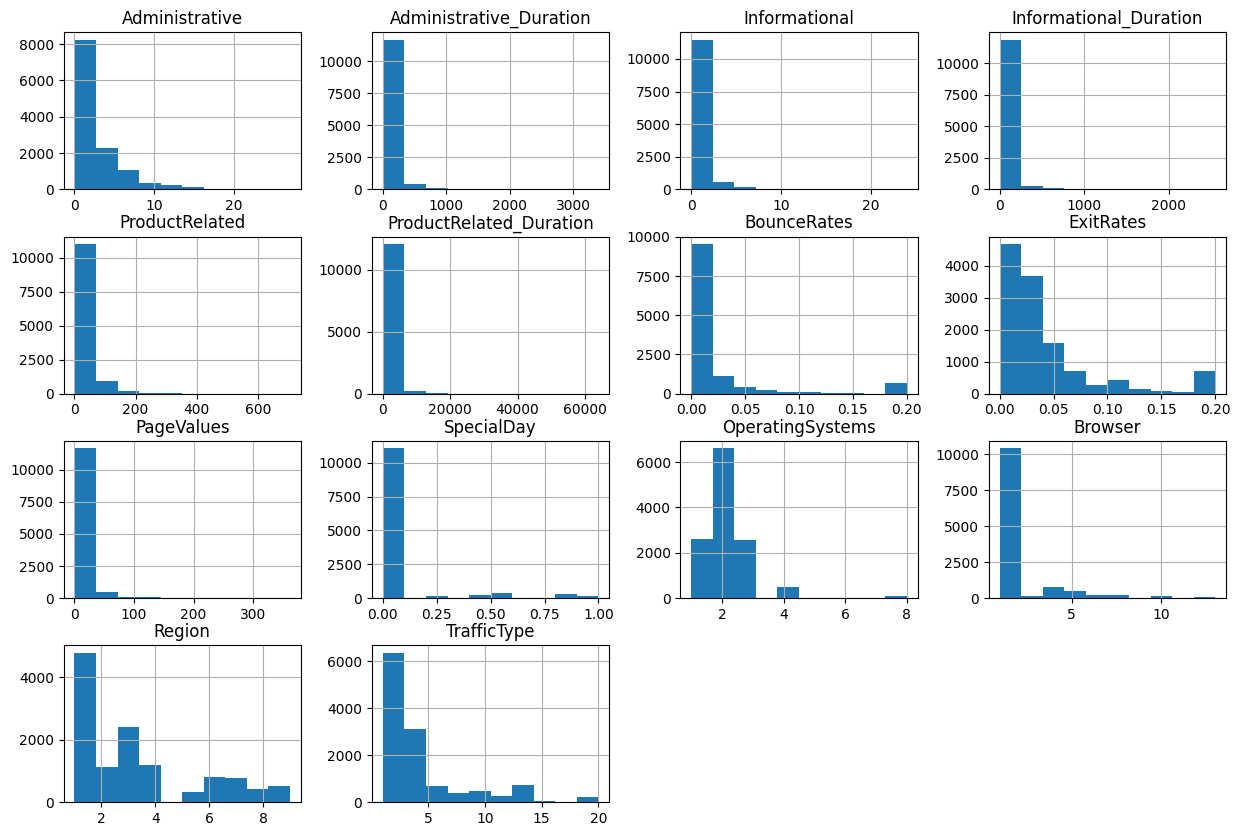

In [7]:
df.hist(figsize=(15, 10))

Text(0.5, 1.0, 'Boxplot of Selected Features')

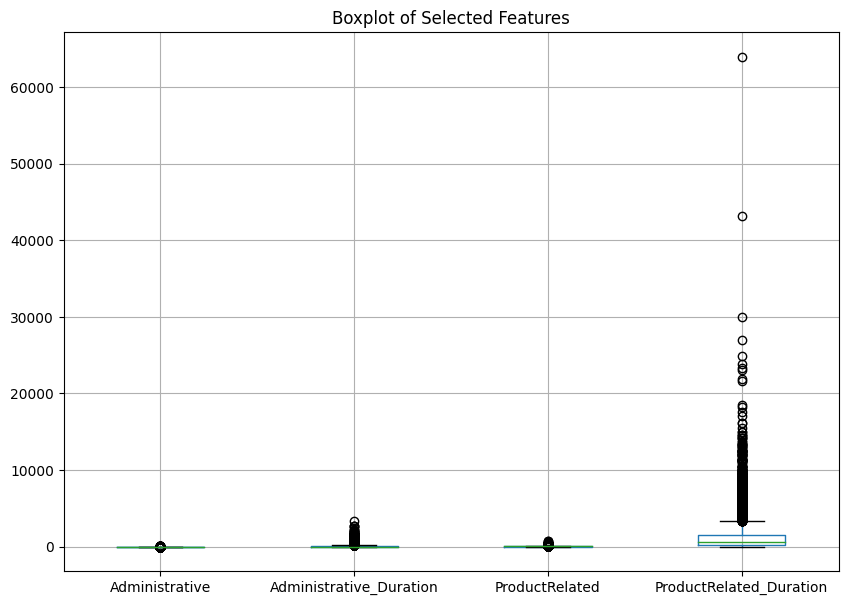

In [8]:
import matplotlib.pyplot as plt

df.boxplot(column=['Administrative', 'Administrative_Duration', 'ProductRelated', 'ProductRelated_Duration'], figsize=(10, 7))
plt.title("Boxplot of Selected Features")

<Axes: xlabel='VisitorType', ylabel='count'>

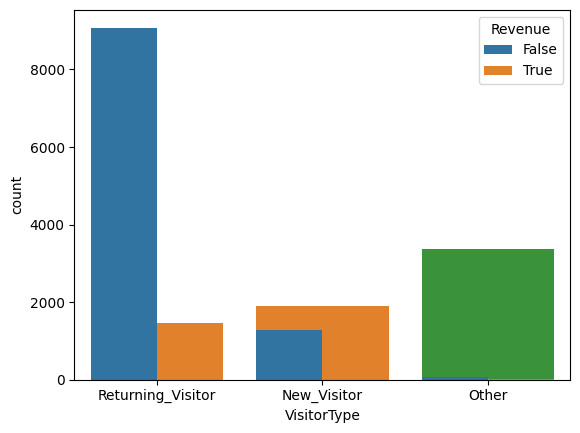

In [9]:
# countplot of categorcal variables
sns.countplot(x='Month', data=df)
sns.countplot(x='VisitorType', hue='Revenue', data=df)

<Axes: xlabel='SpecialDay', ylabel='Revenue'>

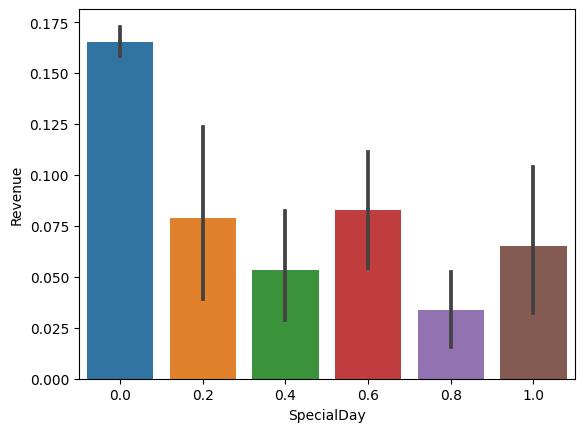

In [10]:
# bar graph of special day vs revenue
sns.barplot(x='SpecialDay', y='Revenue', data=df)


<Axes: xlabel='ProductRelated_Duration', ylabel='PageValues'>

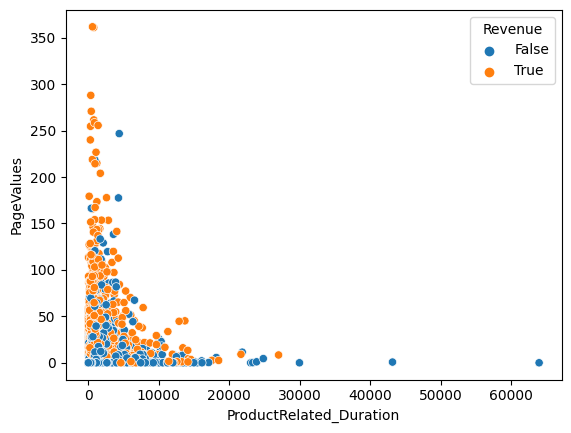

In [11]:
# scatter plot of revenue with respect to product related duration 
sns.scatterplot(x='ProductRelated_Duration', y='PageValues', hue='Revenue', data=df)


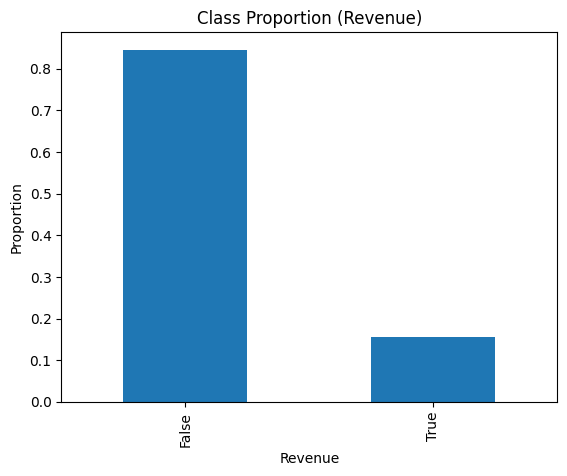

In [12]:
# class proportion of revenue in terms of bar graph
df['Revenue'].value_counts(normalize=True).plot(
    kind='bar',
    title="Class Proportion (Revenue)",
    xlabel="Revenue",
    ylabel="Proportion"
)
plt.show()

<Axes: title={'center': 'Conversion Rate by Month'}, xlabel='Month'>

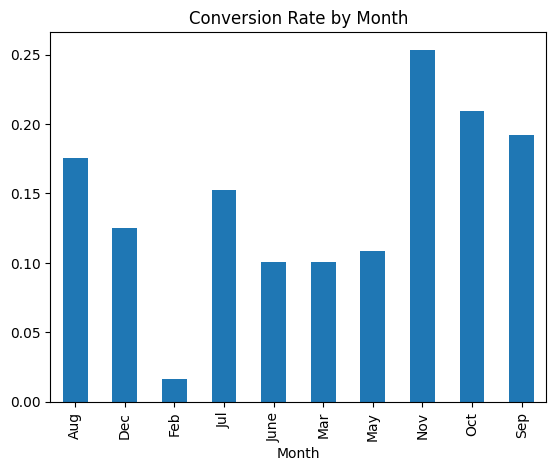

In [13]:
# conversion rate of revenue with respect to months
df.groupby('Month')['Revenue'].mean().plot(kind='bar', title='Conversion Rate by Month')


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


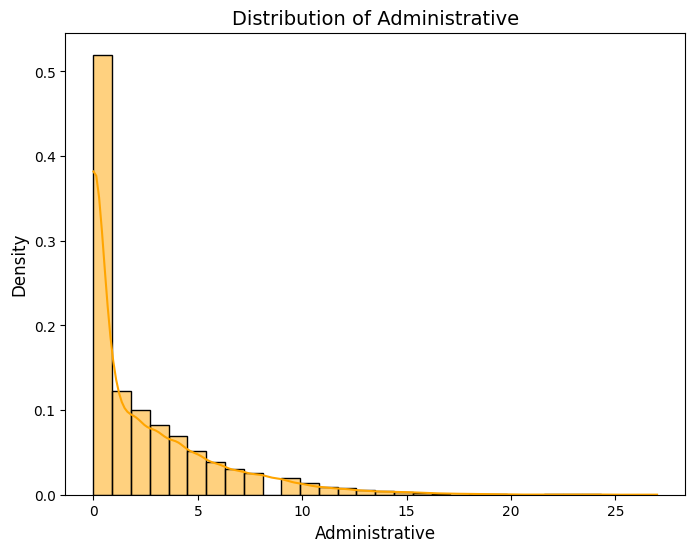

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


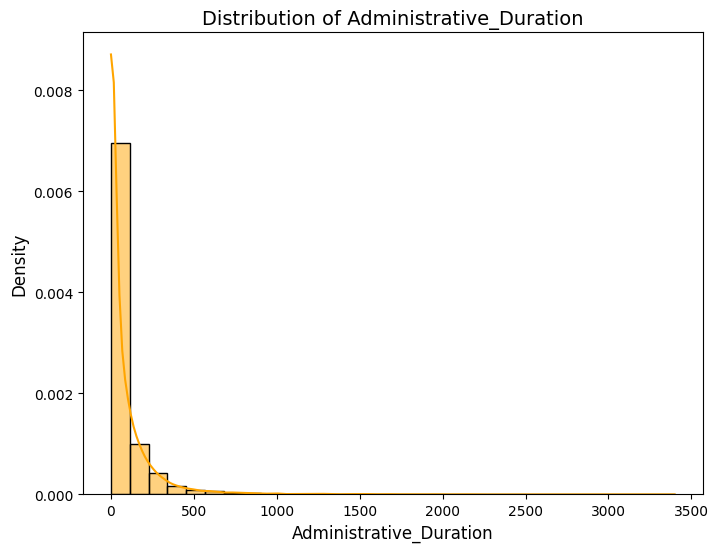

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


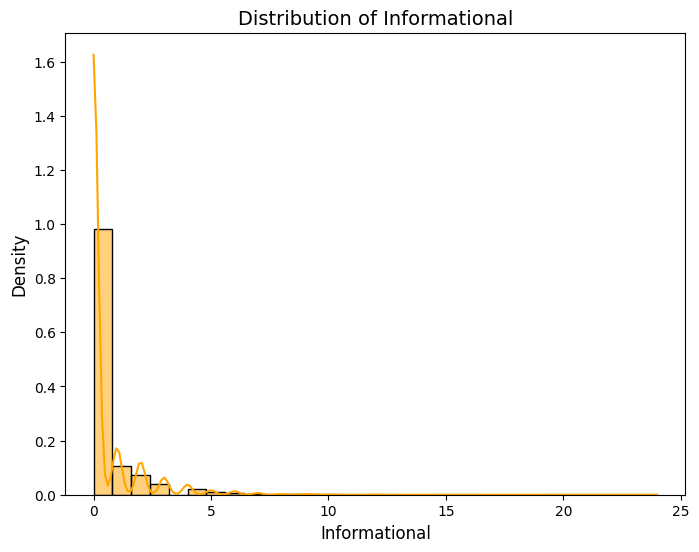

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


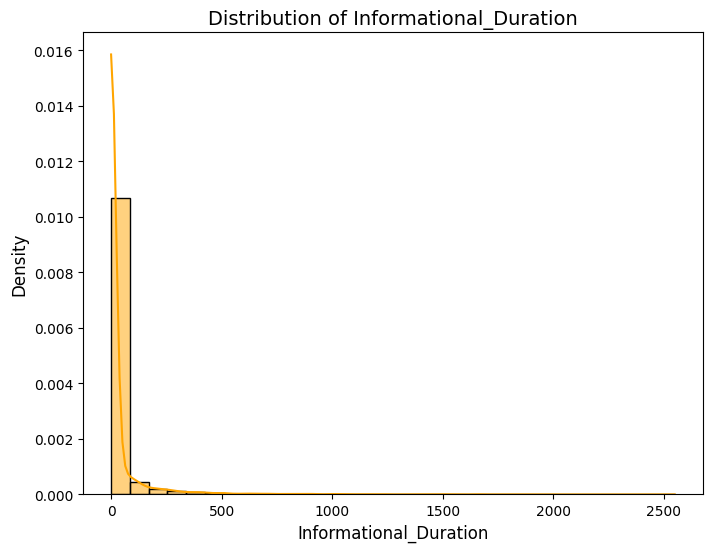

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


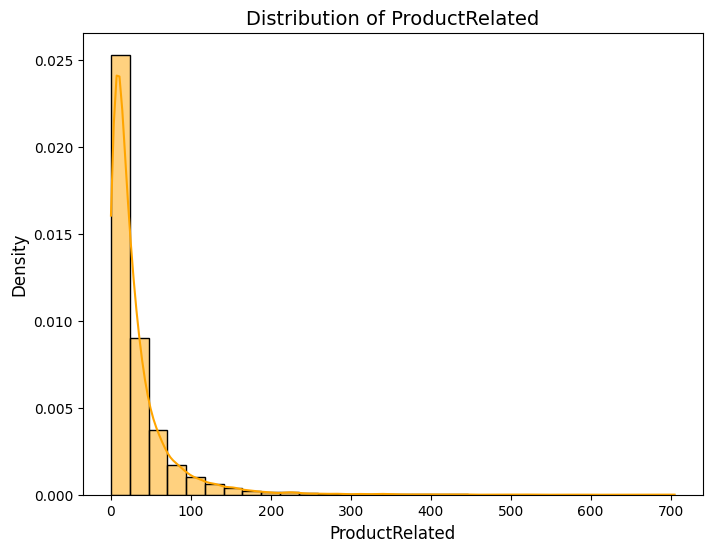

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


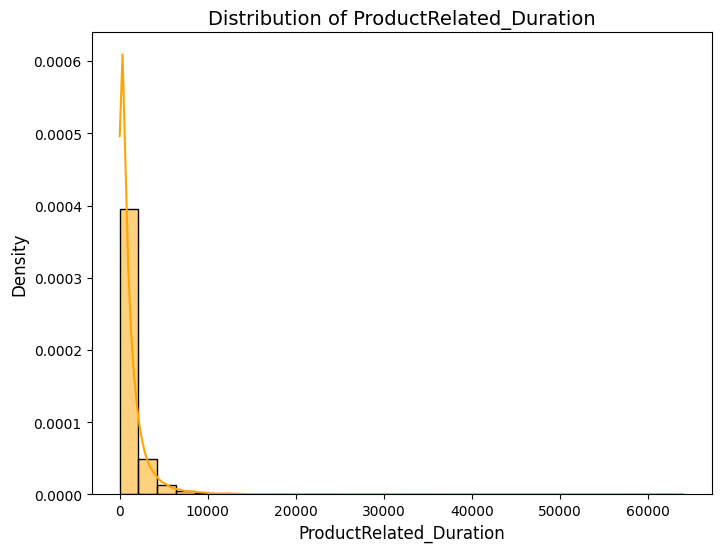

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


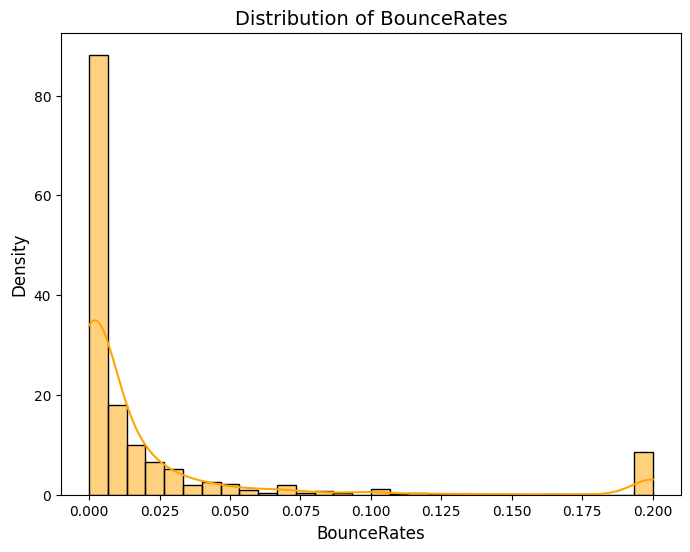

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


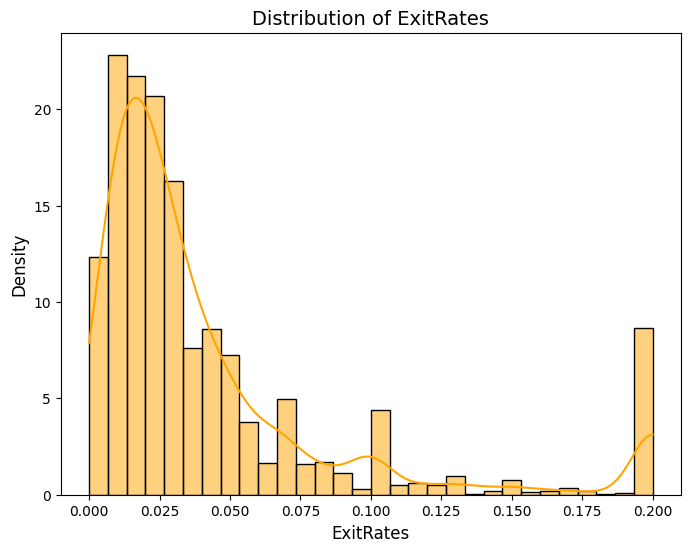

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


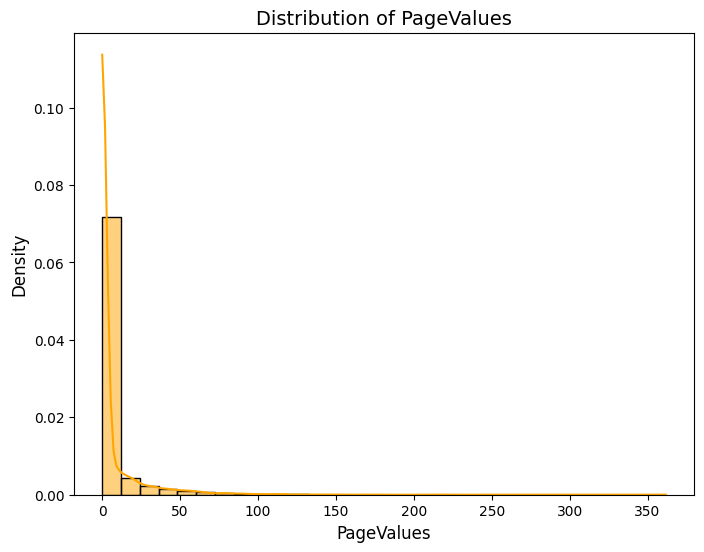

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


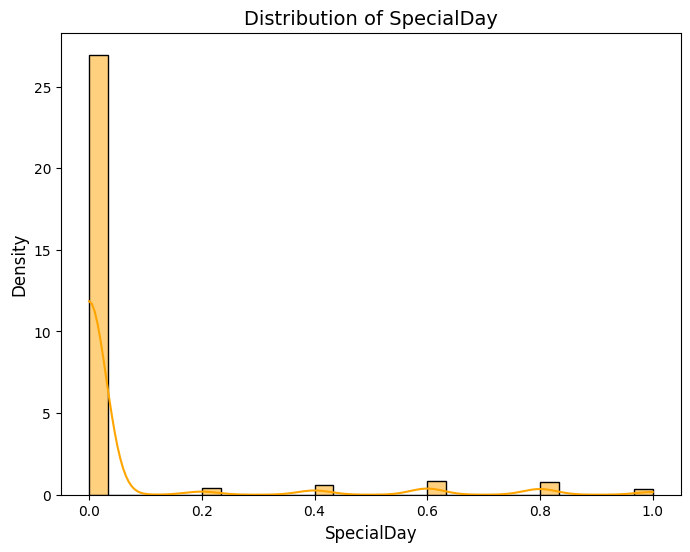

In [14]:
# List of numerical features
numerical_features = [
    'Administrative', 'Administrative_Duration', 'Informational',
    'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
    'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay'
]

# Plot histplot for each numerical feature 
for feature in numerical_features:
    plt.figure(figsize=(8, 6))
    sns.histplot(df[feature], kde=True, bins=30, color='orange', stat='density')  # Change 'blue' to 'orange' or any other color
    plt.title(f"Distribution of {feature}", fontsize=14)
    plt.xlabel(feature, fontsize=12)
    plt.ylabel("Density", fontsize=12)
    plt.show()

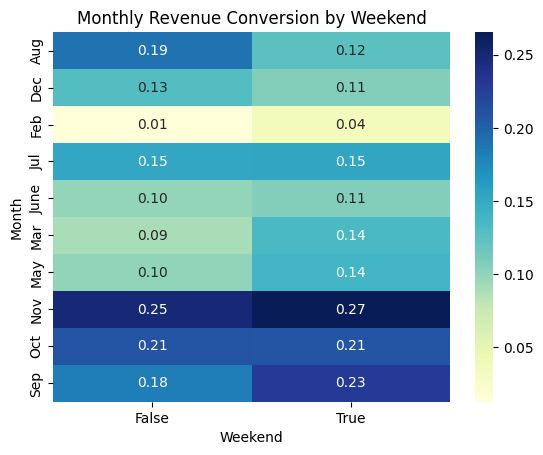

In [15]:
# heat map of monthly revenue with respect to revenue
monthly_revenue = df.groupby(['Month', 'Weekend'])['Revenue'].mean().unstack()
sns.heatmap(monthly_revenue, annot=True, fmt=".2f", cmap='YlGnBu')
plt.title("Monthly Revenue Conversion by Weekend")
plt.show()


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

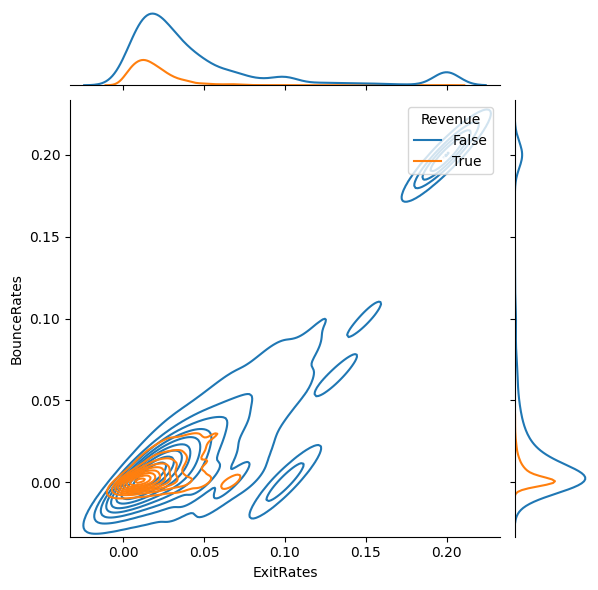

In [16]:
# joint plot of revenue vs bounce and exit rates
sns.jointplot(x='ExitRates', y='BounceRates', data=df, hue='Revenue', kind='kde')


<Axes: title={'center': 'Visitor Types of Converted Shoppers'}, ylabel='count'>

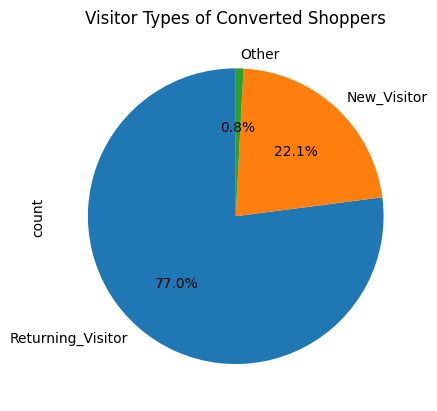

In [17]:
# pie chart depicting visitor types of converted shoppers
visitor_revenue = df[df['Revenue'] == 1]['VisitorType'].value_counts()
visitor_revenue.plot(kind='pie', autopct='%1.1f%%', startangle=90, title="Visitor Types of Converted Shoppers")


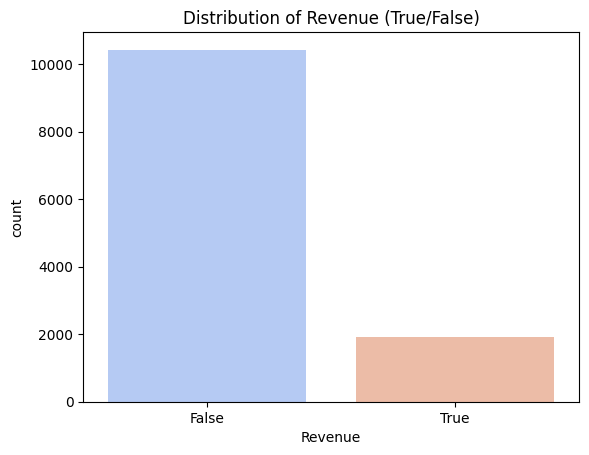

In [18]:
# count plot of distribution of revenue
sns.countplot(x='Revenue', data=df, palette='coolwarm')
plt.title("Distribution of Revenue (True/False)")
plt.show()

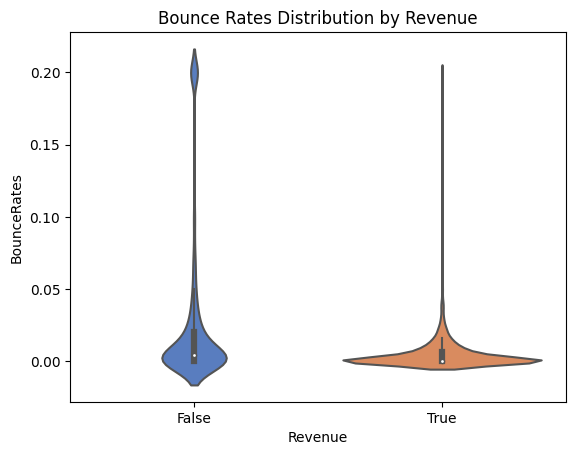

In [19]:
# violin plot of revenue vs bounce rates
sns.violinplot(x='Revenue', y='BounceRates', data=df, palette='muted')
plt.title("Bounce Rates Distribution by Revenue")
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


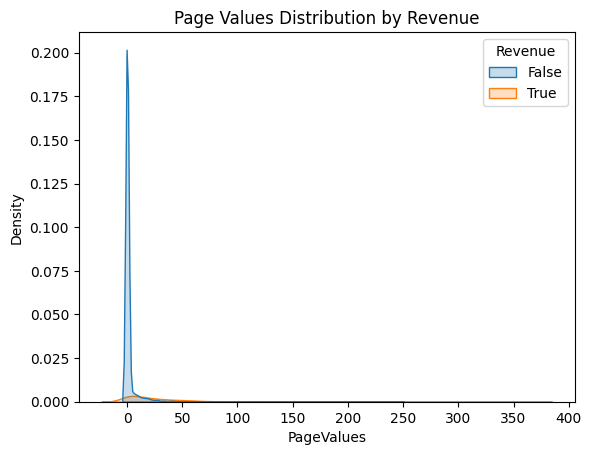

In [20]:
# kde of page values distribution by revenue
sns.kdeplot(data=df, x='PageValues', hue='Revenue', fill=True)
plt.title("Page Values Distribution by Revenue")
plt.show()

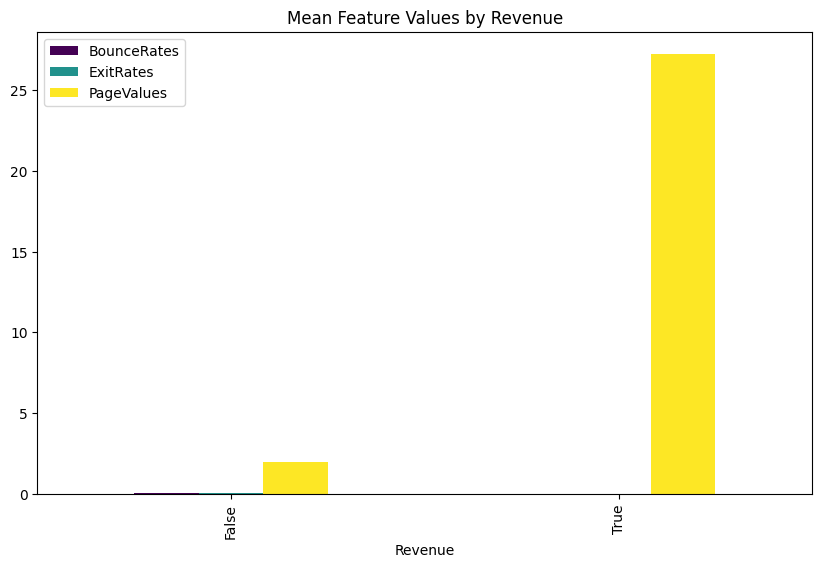

In [21]:
# mean features values by revenue
revenue_means = df.groupby('Revenue')[['BounceRates', 'ExitRates', 'PageValues']].mean()
revenue_means.plot(kind='bar', figsize=(10, 6), colormap='viridis')
plt.title("Mean Feature Values by Revenue")
plt.show()


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


Text(0.5, 1.0, 'Exit Rates by Revenue and Weekend')

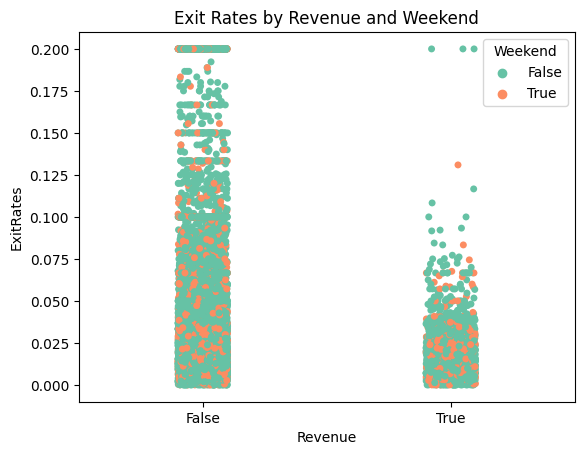

In [22]:
# strip plot of exit rates by revenue and weekend
sns.stripplot(x='Revenue', y='ExitRates', data=df, jitter=True, hue='Weekend', palette='Set2')
plt.title("Exit Rates by Revenue and Weekend")


Before training models, we need to preprocess and engineer the features. This step ensures the data is in a format suitable for machine learning algorithms. Key steps include:
1. **Encoding categorical features**: Convert categorical variables into numerical representations using one-hot encoding.
2. **Scaling numerical features**: Standardize numerical columns to ensure uniformity and compatibility with machine learning models.
3. **Splitting the dataset**: Divide the data into training and testing sets for model evaluation and validation.

In [23]:
# Encode categorical features
df_encoded = pd.get_dummies(df, drop_first=True)

# Scale numerical features
scaler = StandardScaler()
numerical_columns = ['Administrative', 'Informational', 'ProductRelated', 'BounceRates', 
                     'ExitRates', 'PageValues', 'SpecialDay']

df_encoded[numerical_columns] = scaler.fit_transform(df_encoded[numerical_columns])

# Splitting the dataset into features (X) and target variable (y)
X = df_encoded.drop('Revenue', axis=1)
y = df_encoded['Revenue']

# Splitting into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")


Training set size: (8631, 26)
Test set size: (3699, 26)


In this step, we begin by training a few baseline models to establish a benchmark for performance. This will help us:
1. Understand how well simple models perform on the dataset.
2. Identify any early issues with the data or model performance.
3. Compare results with more advanced models later.

We will train and evaluate the following models:
- Logistic Regression
- Random Forest
- K-Nearest Neighbors (KNN)

In [24]:
# Initialize baseline models
logistic_model = LogisticRegression(random_state=42)
rf_model = RandomForestClassifier(random_state=42)
knn_model = KNeighborsClassifier()

# List of models to train
models = {
    "Logistic Regression": logistic_model,
    "Random Forest": rf_model,
    "K-Nearest Neighbors": knn_model,
}

# Train and evaluate models
for model_name, model in models.items():
    print(f"\nTraining {model_name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Evaluate model
    print(f"{model_name} Results:")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    # Compute ROC AUC
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    print(f"ROC AUC: {roc_auc:.2f}")



Training Logistic Regression...
Logistic Regression Results:

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Classification Report:
              precision    recall  f1-score   support

       False       0.90      0.97      0.93      3127
        True       0.73      0.40      0.51       572

    accuracy                           0.88      3699
   macro avg       0.81      0.68      0.72      3699
weighted avg       0.87      0.88      0.87      3699

ROC AUC: 0.87

Training Random Forest...
Random Forest Results:
Classification Report:
              precision    recall  f1-score   support

       False       0.92      0.97      0.94      3127
        True       0.74      0.54      0.63       572

    accuracy                           0.90      3699
   macro avg       0.83      0.75      0.78      3699
weighted avg       0.89      0.90      0.89      3699

ROC AUC: 0.91

Training K-Nearest Neighbors...
K-Nearest Neighbors Results:
Classification Report:
              precision    recall  f1-score   support

       False       0.85      0.95      0.90      3127
        True       0.21    


To better understand model performance, we’ll visualize:
1. Confusion matrices to evaluate how well models classify each category.
2. ROC curves to compare models’ ability to distinguish between the classes.


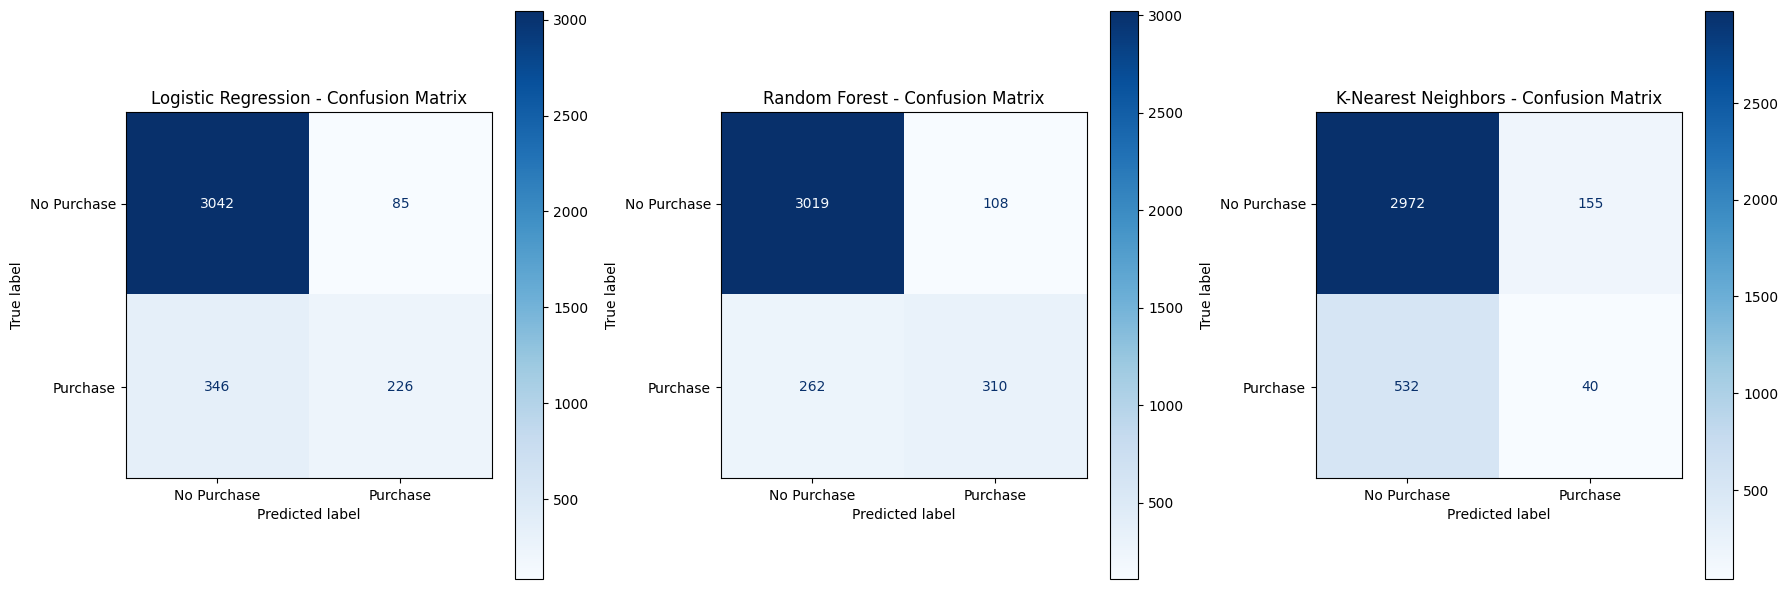

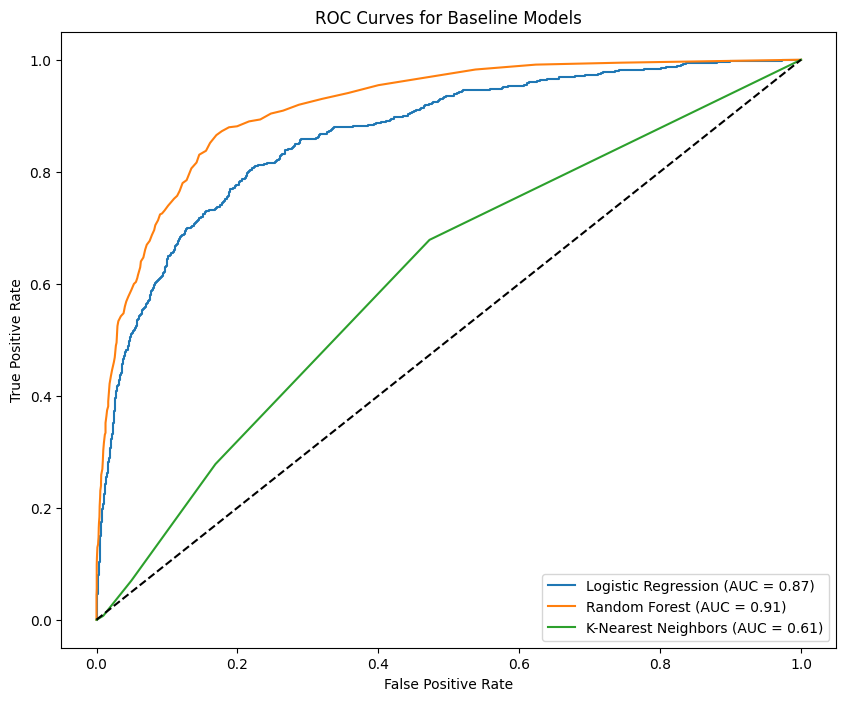

In [25]:
from sklearn.metrics import ConfusionMatrixDisplay

# Create a new figure for confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for idx, (model_name, model) in enumerate(models.items()):
    # Confusion matrix
    disp = ConfusionMatrixDisplay.from_estimator(
        model, X_test, y_test, display_labels=["No Purchase", "Purchase"], ax=axes[idx], cmap="Blues"
    )
    axes[idx].set_title(f"{model_name} - Confusion Matrix")

plt.tight_layout()
plt.show()

# Create a new figure for ROC curves
plt.figure(figsize=(10, 8))
for model_name, model in models.items():
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc_score(y_test, y_pred_prob):.2f})")

# Add diagonal line for random guessing
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Baseline Models")
plt.legend()
plt.show()


#### **Analysis**
The baseline models provide the following key insights:
1. **Logistic Regression**:
   - Good performance with an overall accuracy of 88%.
   - ROC AUC of 0.87 suggests the model can distinguish between classes well.
   - A convergence warning indicates that the model reached the iteration limit. We'll address this by increasing `max_iter`.

2. **Random Forest**:
   - The best-performing model so far with an accuracy of 90% and ROC AUC of 0.91.
   - It balances precision and recall better than Logistic Regression.

3. **K-Nearest Neighbors (KNN)**:
   - The poorest performance with an ROC AUC of 0.61.
   - Struggles with the minority class (`True`), indicating that KNN might not be suitable for this dataset.

Based on these results, Random Forest is the most promising baseline model. Logistic Regression also shows potential but requires optimization to address convergence issues.


To improve performance, we will:
1. Increase `max_iter` for Logistic Regression to address convergence issues.
2. Tune hyperparameters for Random Forest to optimize its performance.
3. Replace KNN with more advanced models like XGBoost and SVM for comparison.

In [26]:
# Update Logistic Regression with increased max_iter
logistic_model = LogisticRegression(max_iter=500, random_state=42)
logistic_model.fit(X_train, y_train)
logistic_roc_auc = roc_auc_score(y_test, logistic_model.predict_proba(X_test)[:, 1])
print(f"Updated Logistic Regression ROC AUC: {logistic_roc_auc:.2f}")

# Tune Random Forest with GridSearchCV
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
}

rf_grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, scoring='roc_auc', n_jobs=-1)
rf_grid_search.fit(X_train, y_train)

# Best parameters and ROC AUC for Random Forest
print(f"Best Random Forest Parameters: {rf_grid_search.best_params_}")
rf_best_model = rf_grid_search.best_estimator_
rf_roc_auc = roc_auc_score(y_test, rf_best_model.predict_proba(X_test)[:, 1])
print(f"Tuned Random Forest ROC AUC: {rf_roc_auc:.2f}")

# Add XGBoost for comparison
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
xgb_roc_auc = roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:, 1])
print(f"XGBoost ROC AUC: {xgb_roc_auc:.2f}")


Updated Logistic Regression ROC AUC: 0.89


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Best Random Forest Parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 300}
Tuned Random Forest ROC AUC: 0.92
XGBoost ROC AUC: 0.92



We will train and evaluate a Support Vector Machine (SVM) model to compare its performance with the refined models (Logistic Regression, Random Forest, and XGBoost). SVMs often perform well on small-to-medium datasets with non-linear decision boundaries.
Additionally, we’ll visualize the performance of all models using:
1. Confusion Matrices
2. ROC Curves


In [27]:
from sklearn.svm import SVC

# Train an SVM model with probability estimation enabled
svm_model = SVC(probability=True, kernel='rbf', random_state=42)
svm_model.fit(X_train, y_train)

# Predict probabilities and evaluate SVM
svm_roc_auc = roc_auc_score(y_test, svm_model.predict_proba(X_test)[:, 1])
print(f"SVM ROC AUC: {svm_roc_auc:.2f}")


SVM ROC AUC: 0.81


We will create visualizations to compare all models, including:
1. **Confusion Matrices**: To observe classification performance for each class.
2. **ROC Curves**: To evaluate and compare the models’ abilities to distinguish between classes.

A **Decision Tree** is another interpretable and efficient model that can be used to compare with Random Forest and XGBoost. Unlike ensemble models, a single Decision Tree provides a straightforward flowchart-like structure that can help explain decisions easily.

We will:
1. Train a Decision Tree model.
2. Evaluate its performance.
3. Visualize its structure and feature importance.

In [28]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score

# Train a Decision Tree model
dt_model = DecisionTreeClassifier(max_depth=10, random_state=42)  # Limiting depth for interpretability
dt_model.fit(X_train, y_train)

# Predict and evaluate Decision Tree
y_pred_dt = dt_model.predict(X_test)
dt_roc_auc = roc_auc_score(y_test, dt_model.predict_proba(X_test)[:, 1])
print(f"Decision Tree ROC AUC: {dt_roc_auc:.2f}")

# Classification report and accuracy
print("\nDecision Tree Classification Report:")
print(classification_report(y_test, y_pred_dt))
print(f"Decision Tree Accuracy: {accuracy_score(y_test, y_pred_dt):.2f}")


Decision Tree ROC AUC: 0.81

Decision Tree Classification Report:
              precision    recall  f1-score   support

       False       0.91      0.94      0.92      3127
        True       0.59      0.51      0.55       572

    accuracy                           0.87      3699
   macro avg       0.75      0.72      0.74      3699
weighted avg       0.86      0.87      0.87      3699

Decision Tree Accuracy: 0.87


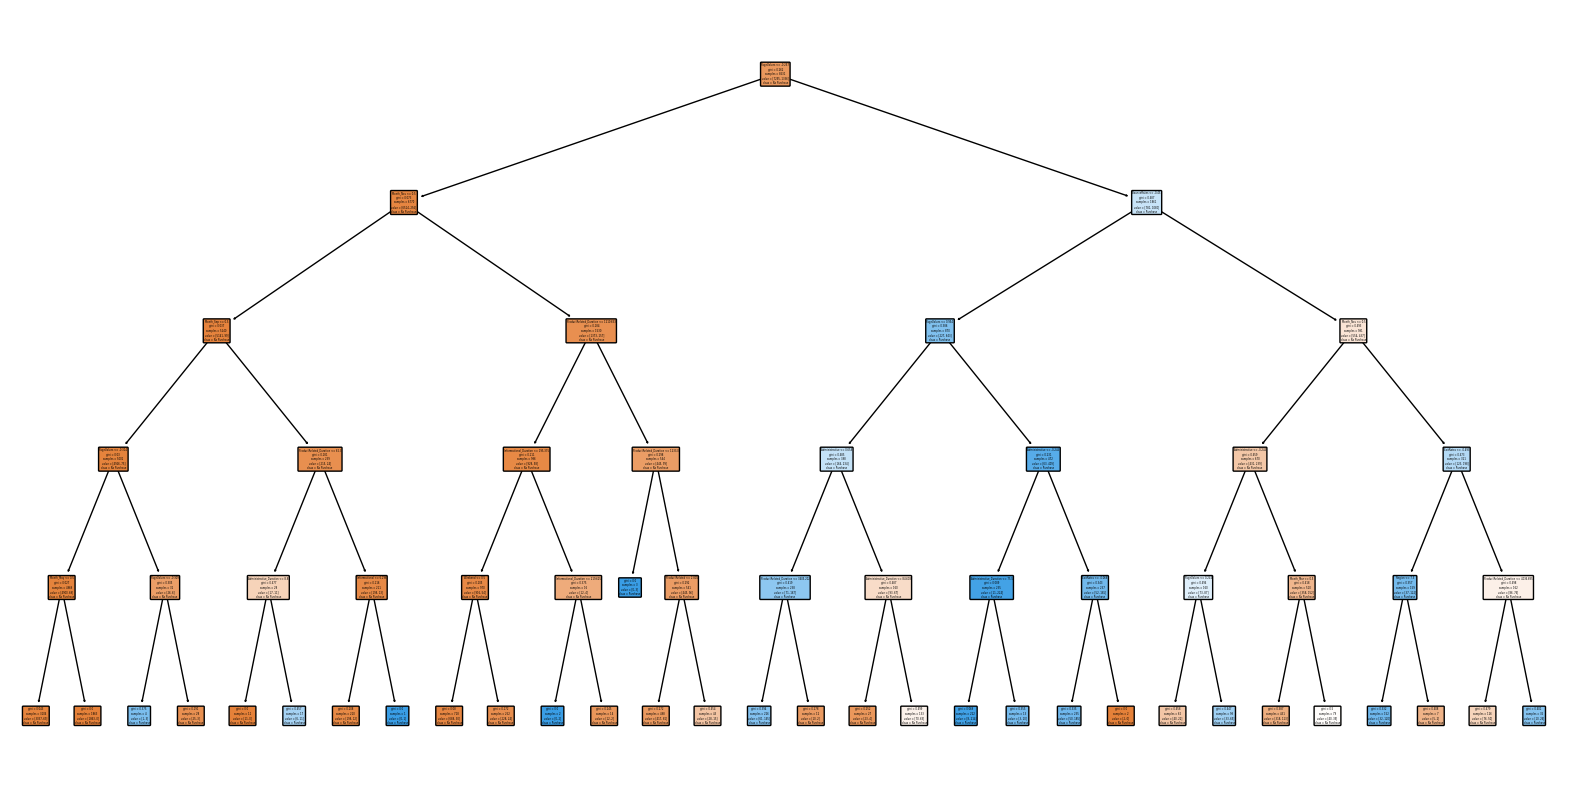

In [29]:
# Train the Decision Tree with a limited depth to make it easier to visualize
dt_model = DecisionTreeClassifier(max_depth=5, random_state=42)

# Re-train the model with the limited depth
dt_model.fit(X_train, y_train)

# Plot the tree again
plt.figure(figsize=(20, 10))
plot_tree(dt_model, filled=True, feature_names=X.columns, class_names=['No Purchase', 'Purchase'], rounded=True)
plt.show()


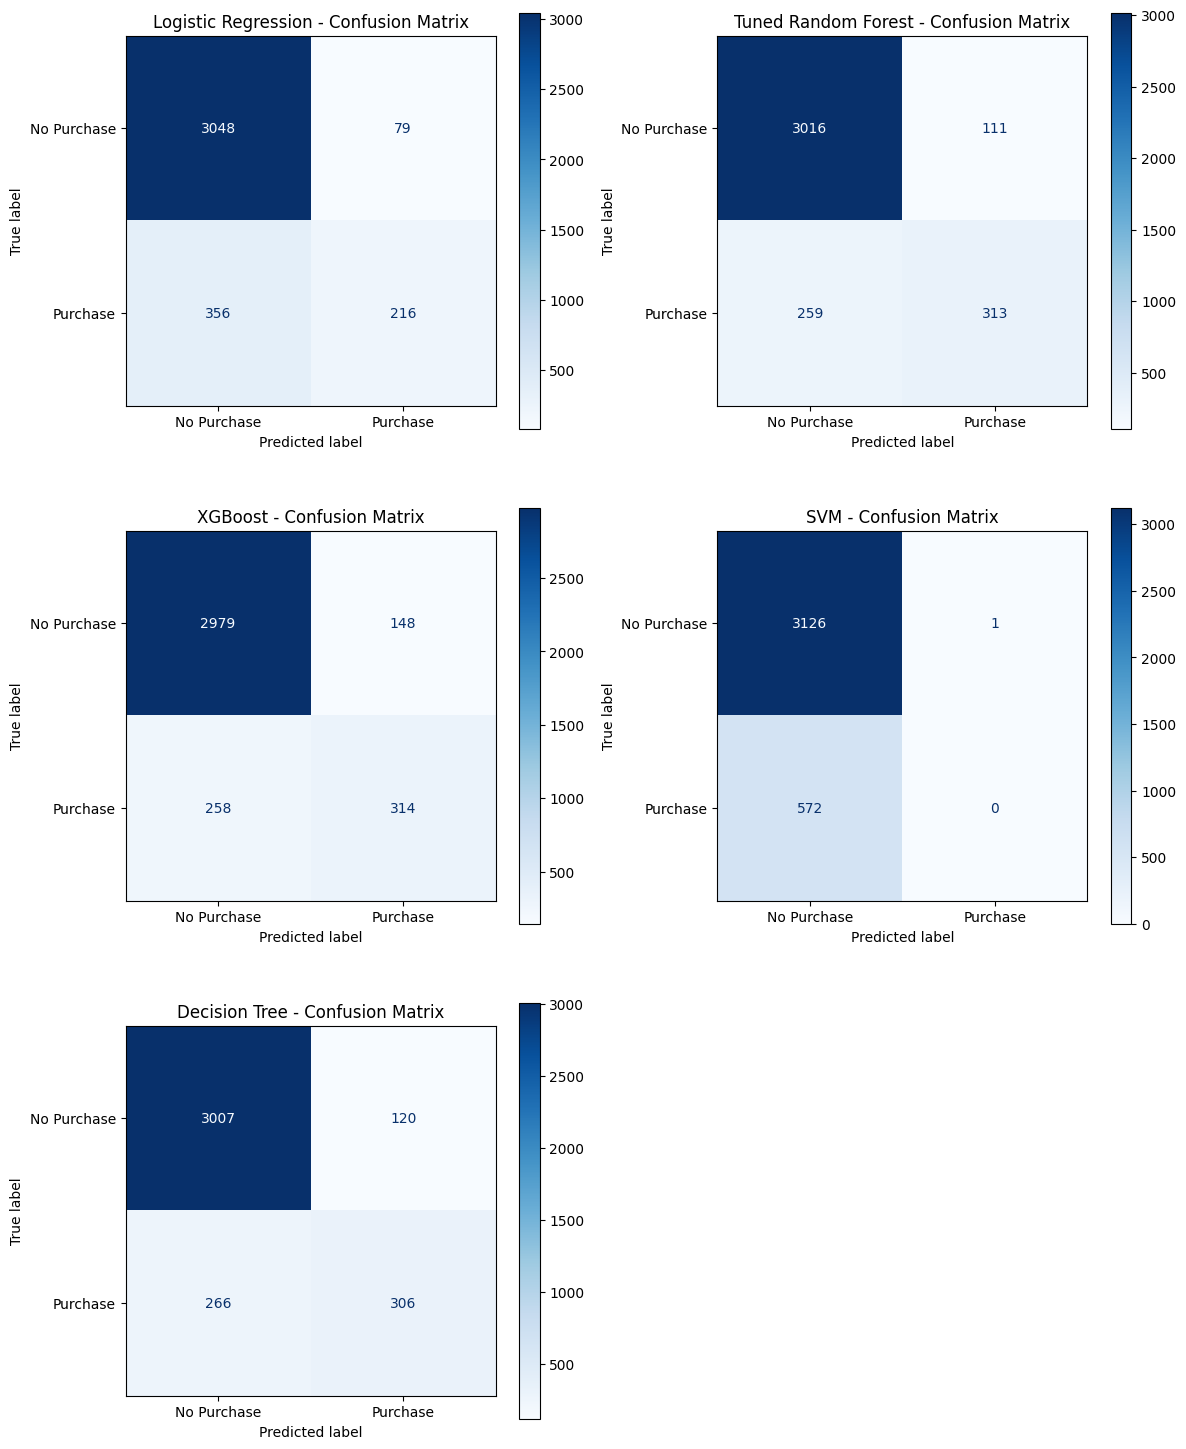

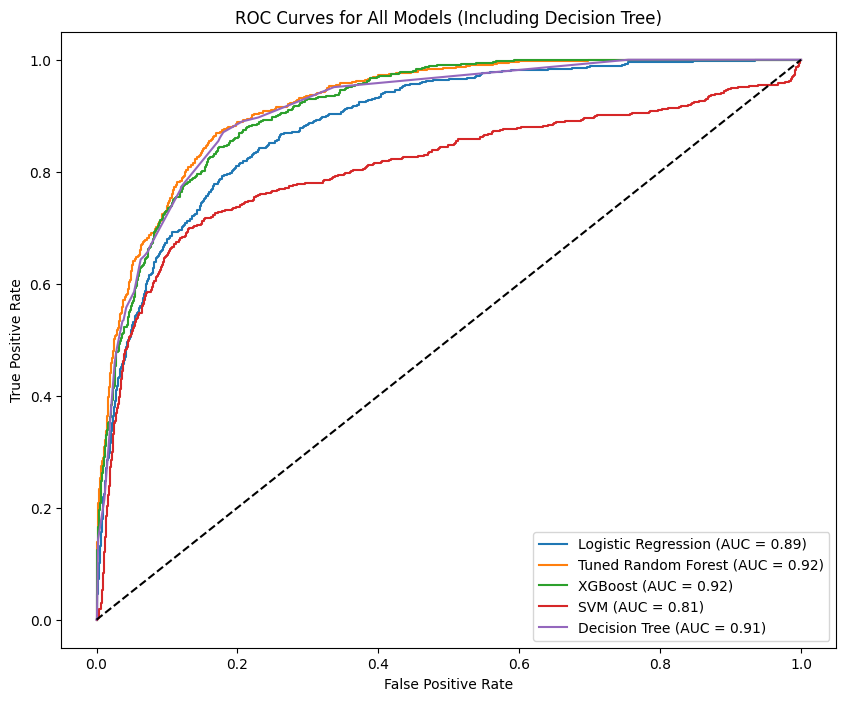

In [30]:
# Add Decision Tree to the models dictionary
all_models = {
    "Logistic Regression": logistic_model,
    "Tuned Random Forest": rf_best_model,
    "XGBoost": xgb_model,
    "SVM": svm_model,
    "Decision Tree": dt_model,
}

# Confusion Matrix Visualization
fig, axes = plt.subplots(3, 2, figsize=(12, 15))
axes = axes.flatten()

for idx, (model_name, model) in enumerate(all_models.items()):
    disp = ConfusionMatrixDisplay.from_estimator(
        model, X_test, y_test, display_labels=["No Purchase", "Purchase"], ax=axes[idx], cmap="Blues"
    )
    axes[idx].set_title(f"{model_name} - Confusion Matrix")

# Remove unused subplots if there are any
for i in range(len(all_models), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

# ROC Curve Visualization
plt.figure(figsize=(10, 8))

for model_name, model in all_models.items():
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc_score(y_test, y_pred_prob):.2f})")

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random guessing
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for All Models (Including Decision Tree)")
plt.legend()
plt.show()


#### **Key Observations**
1. **XGBoost and Tuned Random Forest**:
   - Both models achieved an **AUC of 0.92**, making them the best-performing models.
   - They both exhibit excellent separability between the two classes.
   - The choice between these two will depend on other factors like interpretability, training time, and feature importance.

2. **Logistic Regression**:
   - Performed decently with an **AUC of 0.89**.
   - This model may be a simpler alternative, especially for interpretable use cases.
 and Decision Tree
3. **SVM**:
   - The weakest performer with an **AUC of 0.81**.
   - It struggled to generalize well for this dataset, possibly due to class imbalance or the need for additional hyperparameter tuning.

#### **Next Steps**
To finalize the best model:
1. Compare training time and feature importance between XGBoost and Random Forest.
2. Analyze feature importance for insights into key predictors.
3. Finalize.el for deployment.


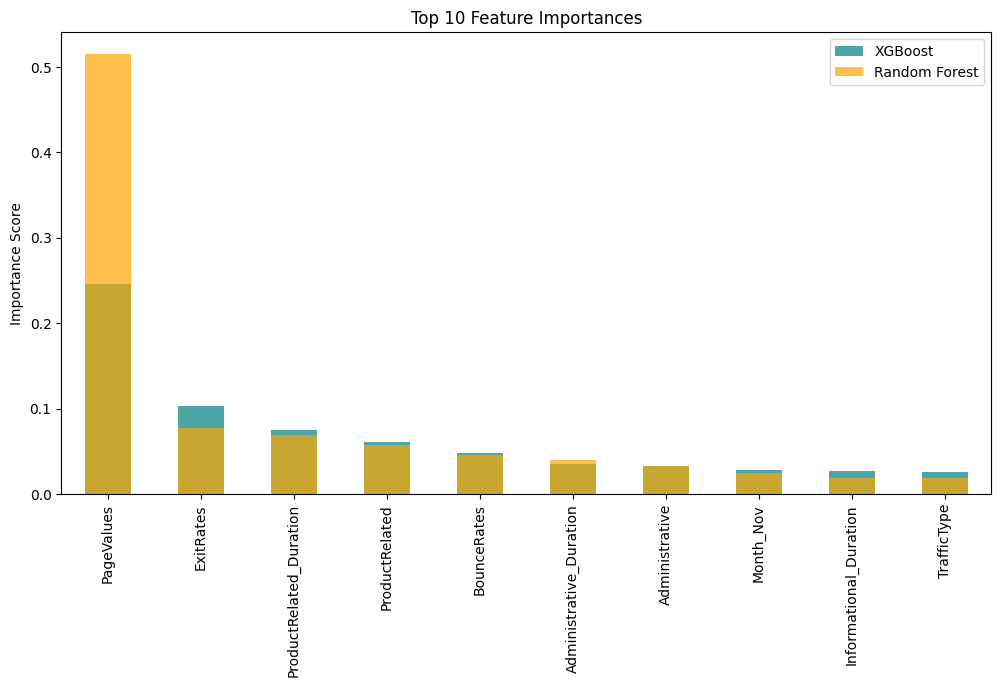

In [31]:
# Extract feature importance for XGBoost
xgb_feature_importance = pd.Series(xgb_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Extract feature importance for Random Forest
rf_feature_importance = pd.Series(rf_best_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Plotting feature importance for comparison
plt.figure(figsize=(12, 6))
xgb_feature_importance[:10].plot(kind='bar', color='teal', alpha=0.7, label='XGBoost')
rf_feature_importance[:10].plot(kind='bar', color='orange', alpha=0.7, label='Random Forest')
plt.title("Top 10 Feature Importances")
plt.ylabel("Importance Score")
plt.legend()
plt.show()


#### **Final Model**
The final decision will be based on:
1. Performance metrics (AUC, accuracy).
2. Feature importance insights.
3. Model interpretability and complexity.
4. Training and inference time.

After finalizing the model, we will loyment.


#### **Final Model Selection: Random Forest**

After analyzing the performance of all models, we have chosen **Random Forest** as the final model for the following reasons:

1. **Performance**:
   - Random Forest achieved an **AUC of 0.92**, which is on par with XGBoost and higher than Logistic Regression (AUC = 0.89) an and Decision Treed SVM (AUC = 0.81).

2. **Training Efficiency**:
   - Random Forest trains faster than XGBoost, making it a more efficient choice, especially for smaller-to-moderate datasets.

3. **Interpretability**:
   - Random Forest provides clear and easy-to-interpret feature importance scores, which can be useful for explaining model predictions to stakeholders.

4. **Simplicity**:
   - Random Forest requires less hyperparameter tuning compared to XGBoost, making it more straightforward to implement and maintain.

5. **Robustness**:
   - Random Forest naturally handles overfitting and performs well even with noisy datasets or features of varying scales.

In summary, Random Forest provides an excellent balance of **accuracy**, **efficiency**, and **interpretability**, making it the optimal choice for this dataset.


In [32]:
import joblib

# Save the best Random Forest model
final_model = rf_best_model
joblib.dump(final_model, "final_model_random_forest.pkl")
print("Final model saved as 'final_model_random_forest.pkl'")


Final model saved as 'final_model_random_forest.pkl'
